In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from IPython.core.display import display
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from multi_imbalance.datasets import load_datasets
from multi_imbalance.resampling.SOUP import SOUP
from multi_imbalance.resampling.MDO import MDO
from multi_imbalance.resampling.GlobalCS import GlobalCS

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from multi_imbalance.resampling.spider import SPIDER3

import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
datasets = load_datasets()

In [3]:
for dataset_name, dataset in datasets.items():
    print(dataset_name, Counter(dataset.target))

1czysty-cut Counter({0: 840, 2: 240, 1: 120})
2delikatne-cut Counter({0: 840, 2: 240, 1: 120})
3mocniej-cut Counter({0: 840, 2: 240, 1: 120})
4delikatne-bezover-cut Counter({0: 840, 2: 240, 1: 120})
balance-scale Counter({2: 288, 1: 288, 0: 49})
cleveland Counter({0: 164, 1: 55, 2: 36, 3: 35, 4: 13})
cleveland_v2 Counter({0: 219, 1: 36, 2: 35, 3: 13})
cmc Counter({0: 629, 2: 511, 1: 333})
dermatology Counter({0: 112, 2: 72, 1: 61, 4: 52, 3: 49, 5: 20})
glass Counter({1: 76, 0: 70, 3: 29, 5: 17, 2: 13, 4: 9})
hayes-roth Counter({0: 65, 1: 64, 2: 31})
new_ecoli Counter({0: 145, 1: 77, 4: 52, 2: 37, 3: 25})
new_led7digit Counter({3: 108, 5: 99, 0: 98, 2: 94, 4: 52, 1: 49})
new_vehicle Counter({1: 429, 0: 218, 2: 199})
new_winequality-red Counter({0: 681, 1: 638, 2: 199, 3: 81})
new_yeast Counter({0: 463, 1: 429, 8: 244, 7: 168, 6: 51, 5: 44, 4: 35, 3: 30, 2: 20})
thyroid-newthyroid Counter({0: 150, 1: 35, 2: 30})


In [4]:
maj_int_min = {
    "1czysty-cut": {'maj': [0],'int': [2],'min': [1]}, 
    "2delikatne-cut": {'maj': [0],'int': [2],'min': [1]},
    "3mocniej-cut": {'maj': [0],'int': [2],'min': [1]},
    "4delikatne-bezover-cut": {'maj': [0],'int': [2],'min': [1]},
    "balance-scale": {'maj': [2, 1],'int': [],'min': [0]},
    "cleveland": {'maj': [0],'int': [1],'min': [2, 3, 4]},
    "cleveland_v2": {'maj': [0],'int': [],'min': [1,2,3]},
    "cmc": {'maj': [0, 2],'int': [],'min': [1]},
    "dermatology": {'maj': [0,],'int': [2, 1, 4, 3],'min': [5]},
    "glass": {'maj': [1, 0],'int': [3],'min': [5, 2, 4]},
    "hayes-roth": {'maj': [],'int': [],'min': [0,1, 2]},
    "new_ecoli": {'maj': [0],'int': [1,4],'min': [2, 3]},
    "new_led7digit": {'maj': [3, 5, 0, 2,4,1],'int': [],'min': []},
    "new_vehicle": {'maj': [1],'int': [],'min': [0, 2]},
    "new_winequality-red": {'maj': [0, 1],'int': [2],'min': [3]},
    "new_yeast": {'maj': [0, 1],'int': [8, 7],'min': [6,5,4,3,2]},
    "thyroid-newthyroid": {'maj': [0],'int': [],'min': [1,2]}
}

In [25]:
def calc_cost_matrix1(dataset_name):
    #imbalance ratio
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))
    element_count = Counter(datasets[dataset_name].target)
    cardinality_pairs = list(element_count.items())
    cost = np.zeros((len(cardinality_pairs), len(cardinality_pairs)))

    for idx1, card1 in cardinality_pairs:
        for idx2, card2 in cardinality_pairs:
            cost[idx1, idx2] = card1/card2

    np.fill_diagonal(cost, 0)
    #print(cost)
    return cost

def calc_cost_matrix3(dataset_name):
    #default
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))
    np.fill_diagonal(cost, 0)
    return cost

def calc_cost_matrix(dataset_name):
    #default
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))

    X, y = datasets[dataset_name].data, datasets[dataset_name].target
    element_count = Counter(y)
    cardinality_pairs = list(element_count.items())
    for c1,_ in cardinality_pairs:
        for c2,_ in cardinality_pairs:
            f2_overlap_volume = 1
            for i in range(X.shape[1]):
                f2_overlap_volume = f2_overlap_volume * (min(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - max(X[y == c1][:,i].min(), X[y == c2][:,i].min())) / (max(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - min(X[y == c1][:,i].min(), X[y == c2][:,i].min()))
            cost[c2, c1] = f2_overlap_volume
    np.fill_diagonal(cost, 0)
    max_overlap = cost.max()
    cost = cost / max_overlap + np.ones((no_classes, no_classes))
    np.fill_diagonal(cost,0)
    #print(cost)
    return cost

def calc_cost_matrix3(dataset_name):
    #default
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))

    X, y = datasets[dataset_name].data, datasets[dataset_name].target
    element_count = Counter(y)
    cardinality_pairs = list(element_count.items())
    for c1,_ in cardinality_pairs:
        for c2,_ in cardinality_pairs:
            f2_overlap_volume = 1
            for i in range(X.shape[1]):
                f2_overlap_volume = f2_overlap_volume * (min(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - max(X[y == c1][:,i].min(), X[y == c2][:,i].min())) / (max(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - min(X[y == c1][:,i].min(), X[y == c2][:,i].min()))
            cost[c2, c1] = f2_overlap_volume
    np.fill_diagonal(cost, 0)
    max_overlap = cost.max()
    cost = cost / max_overlap + np.ones((no_classes, no_classes))
    np.fill_diagonal(cost,0)
    
    for idx1, card1 in cardinality_pairs:
        for idx2, card2 in cardinality_pairs:
            cost[idx1, idx2] *= card1/card2
    #print(cost)
    return cost

def calc_cost_matrix(dataset_name):
    #default
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))

    X, y = datasets[dataset_name].data, datasets[dataset_name].target
    element_count = Counter(y)
    cardinality_pairs = list(element_count.items())
    for c1,_ in cardinality_pairs:
        for c2,_ in cardinality_pairs:
            f2_overlap_volume = 1
            for i in range(X.shape[1]):
                f2_overlap_volume = f2_overlap_volume * (min(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - max(X[y == c1][:,i].min(), X[y == c2][:,i].min())) / (max(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - min(X[y == c1][:,i].min(), X[y == c2][:,i].min()) + 0.000001)
            cost[c2, c1] = f2_overlap_volume
    np.fill_diagonal(cost, 0)
    max_overlap = cost.max() + 0.000001
    cost = cost / max_overlap + np.ones((no_classes, no_classes))
    np.fill_diagonal(cost,0)
    #print(cost)
    return cost

In [30]:
test()

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base,global,soup,mdo,spider
1czysty-cut,0.937,0.946,0.951,0.966,0.954
2delikatne-cut,0.651,0.676,0.771,0.716,0.739
3mocniej-cut,0.404,0.445,0.543,0.489,0.509
4delikatne-bezover-cut,0.723,0.752,0.874,0.796,0.839
balance-scale,0.247,0.103,0.391,0.192,0.319
cleveland,0.120,0.086,0.125,0.057,0.221
cleveland_v2,0.063,0.054,0.217,0.099,0.200
cmc,0.447,0.450,0.460,0.433,0.410
dermatology,0.905,0.912,0.920,0.955,0.902
glass,0.495,0.721,0.646,0.538,0.592


'ACC'

,base,global,soup,mdo,spider
1czysty-cut,0.958,0.962,0.938,0.961,0.962
2delikatne-cut,0.822,0.832,0.804,0.825,0.828
3mocniej-cut,0.680,0.701,0.632,0.627,0.624
4delikatne-bezover-cut,0.842,0.852,0.828,0.841,0.845
balance-scale,0.619,0.552,0.546,0.625,0.557
cleveland,0.466,0.508,0.386,0.459,0.369
cleveland_v2,0.644,0.653,0.554,0.627,0.545
cmc,0.479,0.473,0.470,0.462,0.425
dermatology,0.915,0.917,0.911,0.951,0.923
glass,0.707,0.692,0.599,0.655,0.608


'MEAN G-MEAN'

base      0.564118
global    0.563118
soup      0.619765
mdo       0.591000
spider    0.610706
dtype: float64

'MEAN ACC'

base      0.727000
global    0.721118
soup      0.681824
mdo       0.717000
spider    0.684235
dtype: float64

In [29]:
def test():
    np.random.seed(0)

    datasets = load_datasets()
    results_g_mean = dict()
    results_acc = dict()

    for dataset_name, dataset_values in datasets.items():
        #if dataset_name == 'dermatology' or dataset_name == 'new_ecoli':
        #    continue
        print(dataset_name)

        X, y = dataset_values.data, dataset_values.target

        #if len(X)>1000:
        #    continue

        results_g_mean[dataset_name]=dict()
        results_acc[dataset_name]=dict()

        for resample in ['base','global', 'soup', 'mdo', 'spider']:

            skf = StratifiedKFold(n_splits=5, random_state=0)
            acc, g_mean = list(),list()
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                error_flag = False
                clf_tree = DecisionTreeClassifier(random_state=0)

                if resample == 'base':
                    X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='soup':
                    soup = SOUP()
                    X_train_resampled, y_train_resampled = soup.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='global':
                    global_cs = GlobalCS()
                    X_train_resampled, y_train_resampled = global_cs.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='smote':
                    try:
                        smote = SMOTE()
                        X_train_resampled, y_train_resampled = smote.fit_sample(np.copy(X_train), np.copy(y_train))
                    except Exception as e:
                        error_flag = True
                        print(resample, dataset_name, e)
                        X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='mdo':
                    mdo = MDO(k=9, k1_frac=0, seed=0)
                    X_train_resampled, y_train_resampled = mdo.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='spider':
                    cost = calc_cost_matrix(dataset_name)
                    clf = SPIDER3(k=5, cost=cost, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'])
                    X_train_resampled, y_train_resampled = clf.fit_transform(X_train.astype(np.float64), y_train)

                clf_tree.fit(X_train_resampled, y_train_resampled)
                y_pred = clf_tree.predict(X_test)
                g_mean.append(geometric_mean_score(y_test, y_pred, correction=0.001))
                acc.append(accuracy_score(y_test, y_pred))

            result_g_mean = None if error_flag else round(np.mean(g_mean),3)
            result_acc = None if error_flag else round(np.mean(acc),3)

            results_g_mean[dataset_name][resample]=result_g_mean
            results_acc[dataset_name][resample]=result_acc

    display("G-MEAN")
    df = pd.DataFrame(results_g_mean).T
    display(df)

    display("ACC")
    df2 = pd.DataFrame(results_acc).T
    display(df2)

    display("MEAN G-MEAN")
    df.fillna(df.median(), inplace=True)
    display(df.mean())

    display("MEAN ACC")
    display(df2.mean())

c:\users\damia\anaconda3\envs\multi-imbalance\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


[[0.         1.20674171 0.99984964 1.00980404 1.         2.        ]
 [1.20674171 0.         1.41953398 1.34338267 1.         1.00493341]
 [0.99984964 1.41953398 0.         1.89339801 1.         0.99952084]
 [1.00980404 1.34338267 1.89339801 0.         1.         1.        ]
 [1.         1.         1.         1.         0.         1.        ]
 [2.         1.00493341 0.99952084 1.         1.         0.        ]]


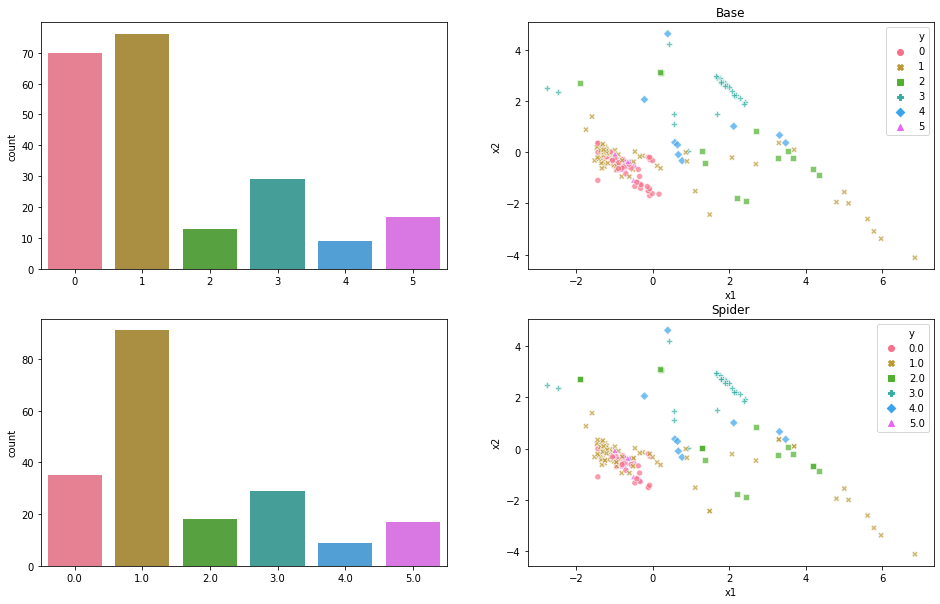

In [8]:


def construct_flat_2pc_df(X, y) -> pd.DataFrame:
    y = pd.DataFrame({'y': y})
    X_df = pd.DataFrame(data=X, columns=['x1', 'x2'])

    df = pd.concat([X_df, y], axis=1)
    return df

dataset = load_datasets()['glass']

X, y = dataset.data, dataset.target

cost = calc_cost_matrix('glass')
clf = SPIDER3(k=5, cost=cost, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'])
resampled_X, resampled_y = clf.fit_transform(X, y)

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches( 16, 10)
axs = axs.flatten()

axs[1].set_title("Base")
sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)


axs[3].set_title("Spider")
sns.countplot(resampled_y, ax=axs[2],palette=p)
resampled_X = pca.transform(resampled_X)
df = construct_flat_2pc_df(resampled_X, resampled_y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[3], legend='full', palette=p)

In [9]:
Counter(datasets['glass'].target)

Counter({0: 70, 5: 17, 4: 9, 1: 76, 3: 29, 2: 13})

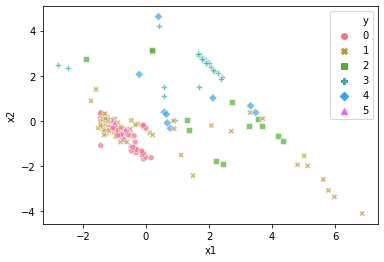

In [10]:
X = pca.transform(datasets['glass'].data)
y = datasets['glass'].target
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, legend='full', palette=p)

In [11]:
X = datasets['glass'].data

In [12]:
y = datasets['glass'].target

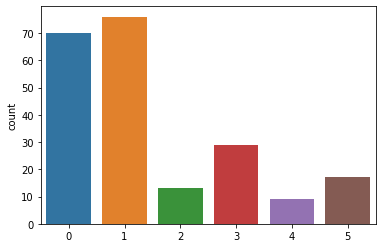

In [13]:
sns.countplot(y)

In [14]:
labels = np.unique(datasets['glass'].target)

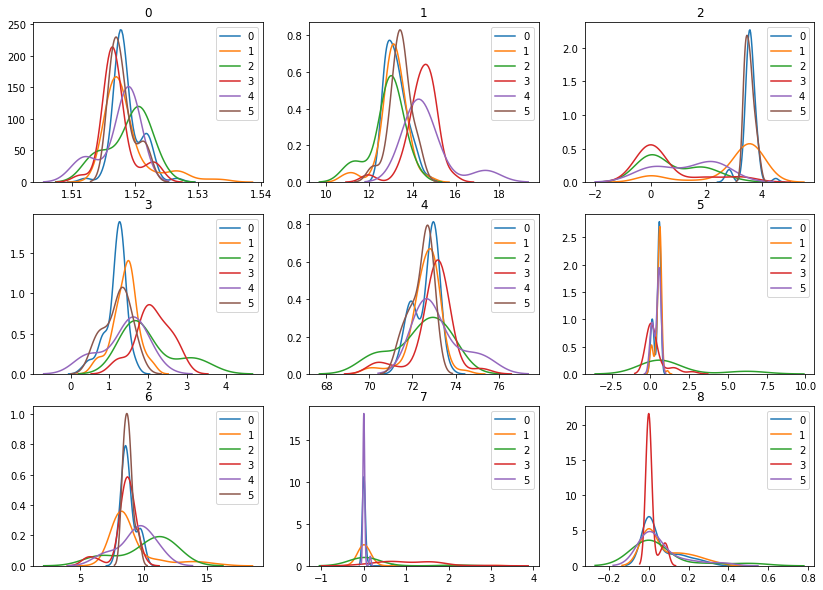

In [15]:
plt.figure(figsize=(14,10))
for i in range(X.shape[1]):
    plt.subplot(3,3,i+1)
    plt.title(i)
    for label in labels:
        try:
            sns.kdeplot(X[y==label][:,i], label=label)
        except:
            pass
plt.show()

In [16]:
df = pd.DataFrame(X)

In [17]:
df['label'] = y

In [18]:
means = df.groupby('label').mean()

In [19]:
stds = df.groupby('label').std()

In [20]:
means

,0,1,2,3,4,5,6,7,8
label,,,,,,,,,
0,1.518718,13.242286,3.552429,1.163857,72.619143,0.447429,8.797286,0.012714,0.057000
1,1.518619,13.111711,3.002105,1.408158,72.598026,0.521053,9.073684,0.050263,0.079737
2,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769
3,1.517116,14.442069,0.538276,2.122759,72.965862,0.325172,8.491379,1.040000,0.013448
4,1.517456,14.646667,1.305556,1.366667,73.206667,0.000000,9.356667,0.000000,0.000000
5,1.517964,13.437059,3.543529,1.201176,72.404706,0.406471,8.782941,0.008824,0.057059


In [21]:
df

,0,1,2,3,4,5,6,7,8,label
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00,0
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00,5
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,0
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00,4
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51610,13.42,3.40,1.22,72.69,0.59,8.32,0.0,0.00,5
210,1.51592,12.86,3.52,2.12,72.66,0.69,7.97,0.0,0.00,1
211,1.51613,13.92,3.52,1.25,72.88,0.37,7.94,0.0,0.14,1
212,1.51689,12.67,2.88,1.71,73.21,0.73,8.54,0.0,0.00,1


In [22]:
max(2,5)

5

In [23]:
max(X[y == 0][:,0].min(), X[y == 1][:,0].min())

1.51409

In [24]:
c1 = 1
c2 = 2
f2_overlap_volume = 1
for i in range(X.shape[1]):
    f2_overlap_volume = f2_overlap_volume * (min(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - max(X[y == c1][:,i].min(), X[y == c2][:,i].min())) / (max(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - min(X[y == c1][:,i].min(), X[y == c2][:,i].min()))
    
f2_overlap_volume

0.0018595269230708212

In [25]:
dataset_name = 'glass'
no_classes = np.unique(datasets[dataset_name].target).size
cost = np.ones((no_classes, no_classes))

X, y = datasets[dataset_name].data, datasets[dataset_name].target
element_count = Counter(y)
cardinality_pairs = list(element_count.items())
for c1,_ in cardinality_pairs:
    for c2,_ in cardinality_pairs:
        f2_overlap_volume = 1
        for i in range(X.shape[1]):
            f2_overlap_volume = f2_overlap_volume * (min(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - max(X[y == c1][:,i].min(), X[y == c2][:,i].min())) / (max(X[y == c1][:,i].max(), X[y == c2][:,i].max()) - min(X[y == c1][:,i].min(), X[y == c2][:,i].min()))
        cost[c2, c1] = f2_overlap_volume
np.fill_diagonal(cost, 0)
max_overlap = cost.max()
cost = cost / max_overlap

c:\users\damia\anaconda3\envs\multi-imbalance\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [26]:
max_overlap

0.004432363071745035

In [27]:
cost

array([[ 0.00000000e+00,  2.06741709e-01, -1.50363005e-04,
         9.80403514e-03, -0.00000000e+00,  1.00000000e+00],
       [ 2.06741709e-01,  0.00000000e+00,  4.19533981e-01,
         3.43382671e-01,  0.00000000e+00,  4.93340697e-03],
       [-1.50363005e-04,  4.19533981e-01,  0.00000000e+00,
         8.93398012e-01, -0.00000000e+00, -4.79164357e-04],
       [ 9.80403514e-03,  3.43382671e-01,  8.93398012e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 1.00000000e+00,  4.93340697e-03, -4.79164357e-04,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00]])